In [305]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import scipy
import statsmodels
##statsmodels.api

In [291]:
%matplotlib inline 
data = pd.read_csv('AB_NYC_2019.csv')

In [44]:
data.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.647,-73.972,Private room,149,1,9,2018-10-19,0.210,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.754,-73.984,Entire home/apt,225,1,45,2019-05-21,0.380,2,355
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.685,-73.960,Entire home/apt,89,1,270,2019-07-05,4.640,1,194
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.748,-73.975,Entire home/apt,200,3,74,2019-06-22,0.590,1,129
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.765,-73.985,Private room,79,2,430,2019-06-24,3.470,1,220


In [292]:
#Some data values (such as row 3) have null values in them. There seems to be 48895 Total entries in this data set
#Meaning there are some null values in name, host_name, but most prominently last_review and reviews_per_month
len(data.index)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [293]:
#null values can present problems if we use them in analysis, so we remove any row that has a null value
#either in name,host_name,last_review, or reviews_per_month.
data=data.dropna()
pd.set_option('display.float_format',lambda x:f'{x:.3f}')
#data[['id','host_id','latitude','longitude','price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']].describe()
data[['price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']].describe()
boxplot = data.boxplot(column=['price','minimum_nights'])

#Some things here such as minimum_nights don't make sense. Typical Airbnb bookings by the median seem to indicate that 
#typical trips take minimum of two nights, and by common sense trips should last around 5-7 days or so. So certain values 
#such as at least 1250 nights do not make sense at all.
#Median price also indicates that the average should be around 100 dollars, yet there are certainly extreme outliers such
#as the maximum value of 10000. Also note that the standard deviation is massive, much bigger than the mean itself, indicating
#the data is not very consistent. Box plot also shows the trend that there are some amount of data values completely outside
#the scope of the typical distribution.

#Let's use the typical [Q1-1.5*IQR,Q3+1.5*IQR] range to denote the data values that are within reason. Hence we obtain
# for price: a range of values from [-82.5, 321.5]   for minimum_nights: [-3.5,8.5]. Logically speaking, these values seem
# to be reasonable. If you are charging more than 321.5 dollars a night, you should be operating a five star hotel. If you are
# requiring your guests to at the very least stay for more than a week, well why?

#Therefore lets remove from the data set values that are not in this range. 

In [294]:
data = data[data['minimum_nights']<9]
data = data[data['price']<321.5]
data[['price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']].describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,32474.000,32474.000,32474.000,32474.000,32474.000,32474.000
mean,117.227,2.569,31.949,1.494,3.375,104.034
std,65.063,1.599,50.564,1.748,21.721,125.304
min,0.000,1.000,1.000,0.010,1.000,0.000
25%,65.000,1.000,3.000,0.220,1.000,0.000
50%,100.000,2.000,11.000,0.870,1.000,39.000
75%,150.000,3.000,38.000,2.260,2.000,191.000
max,321.000,8.000,629.000,58.500,327.000,365.000


In [295]:
print (len(pd.unique(data["neighbourhood"])))

218


In [296]:
neighbors=data.groupby('neighbourhood')
meandata= neighbors.agg({'price':['mean','median','count']}).sort_values(('price','mean'))
meandata.head(10)

#Let us consider the mean here, since we've already removed outliers in the previous step,
#So the data has a reasonable distribution that isn't distorted by outliers. Here, as per 
#the assignment, we only consider those neighborhoods who have more than 5 listings/count.
#Therefore, the 5 lowest neighborhoods by price are: Port Richmond, Tremont, Bronxdale,
#Corona, and Soundview.

price             
                  mean median count
neighbourhood                      
New Dorp Beach  38.000 38.000     2
Little Neck     42.333 45.000     3
Bull's Head     48.000 39.000     3
Port Richmond   48.333 48.500     6
Tremont         49.900 40.500    10
Bronxdale       51.875 47.500    16
Corona          52.214 40.000    56
Soundview       52.846 45.000    13
Olinville       53.000 53.000     2
North Riverdale 59.167 46.500     6

In [297]:
#Similarly here, lets use the mean here to describe the 5 most expensive neighborhoods, while also only considering
#Those with more than 5 listings. Therefore, the five most expensive neighborhoods are: Tribeca, Flatiron District,
#West Village, NoHo, and Financial District. 

meandata.tail(10)

price              
                      mean  median count
neighbourhood                           
Greenwich Village  180.898 185.000   235
Castleton Corners  182.000 182.000     2
Financial District 187.936 200.000   359
NoHo               188.139 184.500    36
West Village       193.124 195.000   451
Flatiron District  194.946 210.000    37
Breezy Point       195.000 195.000     2
Tribeca            197.113 200.000    53
Neponsit           237.000 237.000     2
Willowbrook        249.000 249.000     1

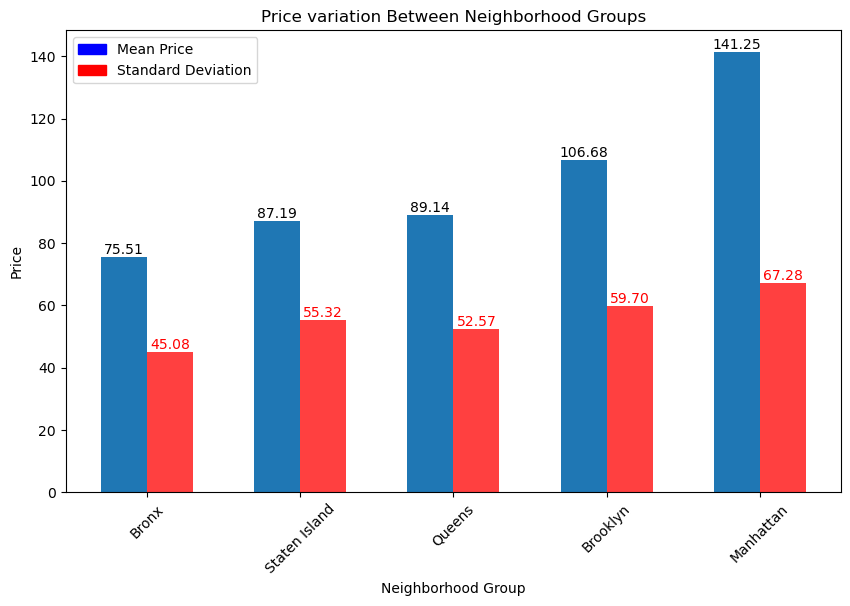

In [299]:
#To show the price variation between different neighbourhood groups, we first group the 
#dataframe based on neighbourhood group and calculate their mean and standard deviation
#for central tendency and variation measures within each neighborhood, then we plot mean and
#standard deviation in a bar graph showing the distribution of each group based on mean and
#standard deviation.

neighbourhood_groups=data.groupby('neighbourhood_group')['price'].agg(['mean','std']).reset_index()
neighbourhood_groups=neighbourhood_groups.sort_values('mean')

position = np.arange(len(neighbourhood_groups))
fig, ax = plt.subplots(figsize=(10,6))

bars_mean = ax.bar(position,neighbourhood_groups['mean'],width=0.3,label ="Mean")
bars_std=ax.bar(position+0.3,neighbourhood_groups['std'],width=0.3,label = "Standard Deviation",alpha=0.75,color='red')
for bar in bars_mean: 
    height = bar.get_height()
    ax.text(bar.get_x()+bar.get_width()/2, height, f'{height:.2f}',ha='center',va='bottom');
    
for bar in bars_std: 
    height = bar.get_height()
    ax.text(bar.get_x()+bar.get_width()/2, height,f'{height:.2f}',ha='center',va='bottom',color='red');
    
plt.xlabel('Neighborhood Group')
plt.ylabel('Price')
plt.title('Price variation Between Neighborhood Groups')
plt.xticks(position+0.3/2,neighbourhood_groups['neighbourhood_group'],rotation=45)
ax.legend(loc='upper right',frameon=False)
ax.legend(handles=[matplotlib.patches.Patch(color='blue',label='Mean Price'),matplotlib.patches.Patch(color='red',label='Standard Deviation')])
plt.show()
    

In [300]:
#Lets take the set of data that are numeric and calculable: Price, minimum nights, reviews per month,
#calculated host listing count, availability365

corr=data[['price','minimum_nights','reviews_per_month','calculated_host_listings_count','availability_365']].corr()
corr

,price,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365
price,1.000,0.090,-0.042,0.103,0.023
minimum_nights,0.090,1.000,-0.263,-0.029,-0.095
reviews_per_month,-0.042,-0.263,1.000,0.028,0.248
calculated_host_listings_count,0.103,-0.029,0.028,1.000,0.129
availability_365,0.023,-0.095,0.248,0.129,1.000


Text(0.5, 1.0, 'Correlation Heatmap')

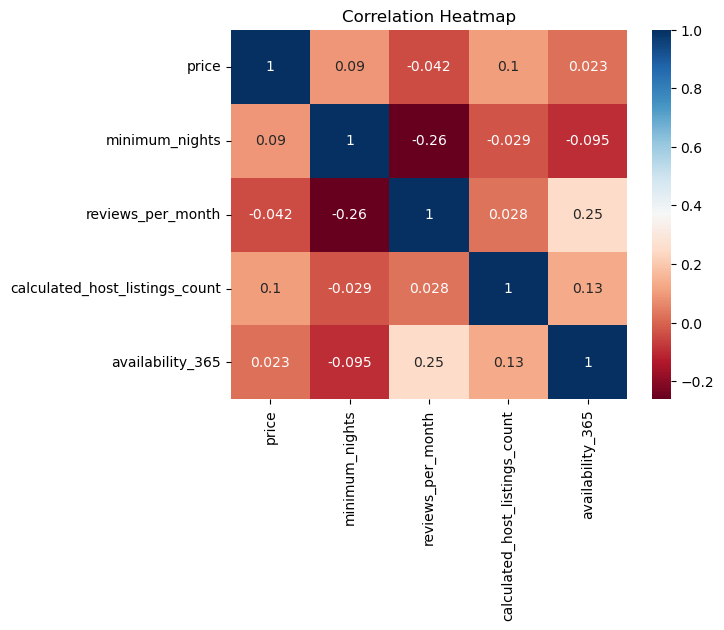

In [301]:
#Draw a heatmatp of the correlations with seaborn:    
seaborn.heatmap(corr,cmap="RdBu",annot=True)
plt.title("Correlation Heatmap")

#Here, we can see that the most positive correlation is 0.25 between reviews_per_month and 
#availability_365. The most negative correlation at -0.26 is between reviews_per_month and
#minimum nights.

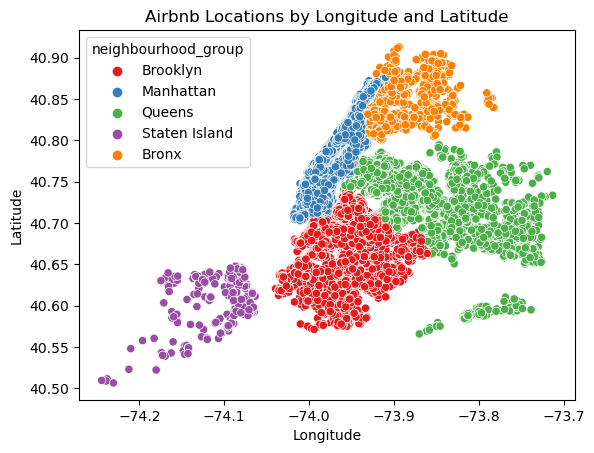

In [302]:
#Now lets plot the latitude and longitude of the airbnb's, color coded by neighbourhood group

seaborn.scatterplot(x='longitude',y='latitude',hue='neighbourhood_group',data=data,palette='Set1')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Airbnb Locations by Longitude and Latitude')
plt.show()

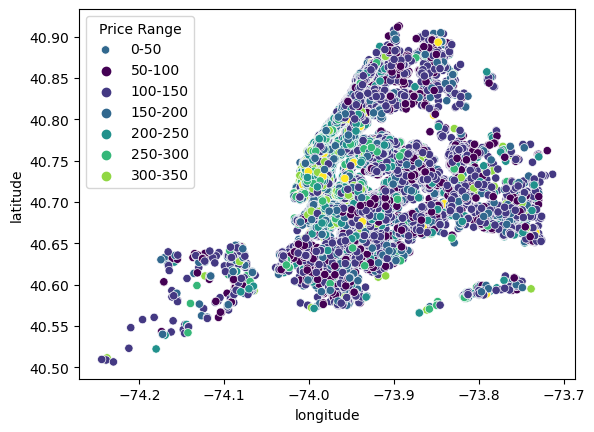

In [303]:
#This time lets color code it based on price range

price_ranges=[0,50,100,150,200,250,300,350]
data['price_range']=pd.cut(data['price'],bins=price_ranges,right=False,labels=False)
seaborn.scatterplot(x='longitude',y='latitude',hue='price_range',data=data,palette='viridis')
legend_labels =[]
for i in range(len(price_ranges)-1):
    x=str(price_ranges[i])
    x+="-"
    x+=str(price_ranges[i+1])
    legend_labels.append(x)
plt.legend(title='Price Range',labels=legend_labels,loc='upper left')
plt.show()

#From the plot shown it is clear to see that the most expensive(light-colored)
#neighbourhood group is Manhattan.

In [189]:
Now lets create a word cloud based on words used in the name/descriptions of Airbnbs

wordcloud.WordCloud(width=600,height=400,background_color='white').generate(text)
ax.imshow(wordcloud,interpolation='bilinear')
ax.set_axis_off();
ax.set_title('Word Cloud of Airbnb Listing names')
plt.show()

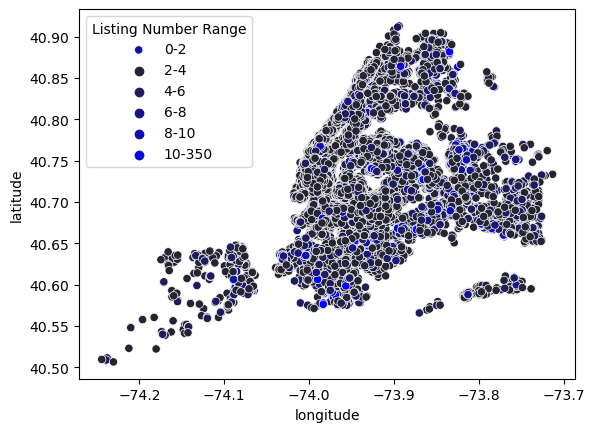

In [306]:
#Now, which areas has the busiest hosts(Highest number of listings)? 
#Let's plot another scatter plot based on location, and color code hosts
#based on the number of listings they get as shown below
data['calculated_host_listings_count'].describe()
listing_ranges=[0,2,4,6,8,10,350]
data['listing_range']=pd.cut(data['calculated_host_listings_count'],bins=listing_ranges,right=False,labels=False)
colors=seaborn.dark_palette("blue",n_colors=6)
seaborn.scatterplot(x='longitude',y='latitude',hue='listing_range',data=data,palette=colors)
listing_range_labels=[];

for i in range(len(listing_ranges)-1):
    x=str(listing_ranges[i])
    x+="-"
    x+=str(listing_ranges[i+1])
    listing_range_labels.append(x)
plt.legend(title="Listing Number Range",labels = listing_range_labels,loc='upper left')
plt.show()

#From the Scatter plot of locations and number of listings, it seems like middle upper areas of
#Queens seem to have the highest number of listings,as well as an area of Southern Bronx, and
#Southern Manhattan seems to be very busy as well.
#Let's group all the hosts by neighbourhoods and check the data.

In [164]:
uniqueiddata=data.drop_duplicates(subset='id',keep='first')
neighbours1=uniqueiddata.groupby('neighbourhood')
bnh=neighbours1.agg({'calculated_host_listings_count':['mean','median','count']}).sort_values(('calculated_host_listings_count','mean'))
bnh.tail(10)

#Lets first check the mean host_listing count and the number of hosts within each neighbourhood to get an idea of
#which has the busiest. However, this may not be entirely predictable as we can see
#some of the ones on here have a very small sample size which may not be predictive, and many times
#a neighbourhood may have very busy hosts that are diluted a lot by hosts that have very little listings
#Also note that with the exception of 3 neighbourhoods, all the other ones have a mean of
#under 10 listings, and many of them have very low medians as well. Therefore, we should also
#consider how many of the hosts are actually busy. Lets consider a host busy if they have >10 
#listings

calculated_host_listings_count             
                                             mean median count
neighbourhood                                                 
Port Morris                                 4.111  3.500    36
Hell's Kitchen                              4.133  1.000  1168
Arrochar                                    4.211  3.000    19
Concord                                     5.091  7.000    22
Far Rockaway                                5.900  1.000    20
NoHo                                        6.389  1.000    36
Co-op City                                  7.000  7.000     2
Eastchester                                13.000 13.000    10
Murray Hill                                44.951  1.000   164
Financial District                        111.485  1.000   359

In [308]:
#Lets consider a host to be busy if they have >=10 listings. 
#Therefore, lets see how many busy hosts each neighbourhood_group has

busydata= data[data['calculated_host_listings_count']>9]
#We also need to only consider unique host values
busydata=busydata.drop_duplicates(subset='host_id',keep="first")
busyneighbourhoods=busydata.groupby('neighbourhood')
bnh=busyneighbourhoods.agg({'calculated_host_listings_count':['mean','count']}).sort_values(('calculated_host_listings_count','mean'))
bnh.tail(20)
#The number of busy hosts are fairly split between these neighbourhoods. Some prominent ones are Bedford-Stuyvesant, Hell's
#Kitchen, Greenpoint, Midtown.
#Lets try to expand this to neighbour_hood_groups

calculated_host_listings_count      
                                             mean count
neighbourhood                                          
Upper West Side                            11.000     2
Crown Heights                              11.000     2
Flushing                                   11.000     2
Gravesend                                  12.000     1
Sunnyside                                  12.000     1
Midtown                                    12.714     7
Financial District                         13.000     1
Eastchester                                13.000     1
Prospect Heights                           13.000     1
East New York                              13.000     2
Theater District                           15.000     1
Chelsea                                    16.000     2
Gowanus                                    17.000     1
Bedford-Stuyvesant                         18.000     5
Bushwick                                   18.000     2
Briarwood                                  18.000     1
Hell's Kitchen                             22.000     5
Greenpoint                                 24.667     3
Far Rockaway                               43.000     1
Murray Hill                               327.000     1

In [310]:
busyneighbourhood=busydata.groupby('neighbourhood_group')
bnh=busyneighbourhood.agg({'calculated_host_listings_count':['mean','count']}).sort_values(('calculated_host_listings_count','mean'))
bnh.tail(20)

#Here, we can clearly see that Manhattan is the busiest host area.

calculated_host_listings_count      
                                              mean count
neighbourhood_group                                     
Bronx                                       11.500     2
Queens                                      15.750     8
Brooklyn                                    15.810    21
Manhattan                                   27.458    24

In [264]:
#Let's try to understand what makes these hosts busy. 
#Lets consider several parameters which might have an impact in relation to # of listings including:
#Price, minimum_nights, number_of_reviews, availability 365
#To do this, we need to group each host into one value, and create a new data frame consisitng of each host's average
#values, we do this by doing
busydata2= data[data['calculated_host_listings_count']>9]
busydata1=pd.DataFrame(busydata2.groupby('host_id').mean())
busydata1=busydata1[busydata1['price']<321]
busydata1=busydata1[busydata1['minimum_nights']<9]
#Lets create a correlation heatmap of all of these values to gain a general understanding
#Let's look at the first row of data

corr1=busydata1[['calculated_host_listings_count','price','minimum_nights','number_of_reviews','availability_365']].corr()
corr1

C:\Users\jerry\AppData\Local\Temp\ipykernel_38552\4253895627.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  busydata1=pd.DataFrame(busydata2.groupby('host_id').mean())


,calculated_host_listings_count,price,minimum_nights,number_of_reviews,availability_365
calculated_host_listings_count,1.000,0.150,0.028,-0.110,0.080
price,0.150,1.000,-0.167,-0.115,0.013
minimum_nights,0.028,-0.167,1.000,-0.192,-0.160
number_of_reviews,-0.110,-0.115,-0.192,1.000,-0.137
availability_365,0.080,0.013,-0.160,-0.137,1.000


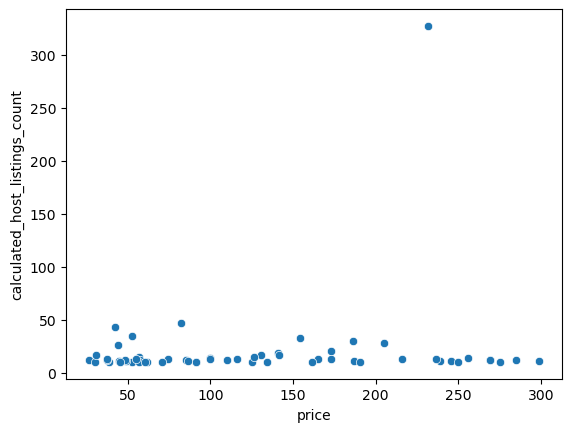

In [311]:


seaborn.scatterplot(x='price',y='calculated_host_listings_count',data=busydata1)
plt.show()
#However we can see here the scatter plot doesn't clearly show a positive effect,
#Lets try the spearman correlation



In [277]:
corre,p_value= scipy.stats.spearmanr(busydata1['price'],busydata1['calculated_host_listings_count'])
print(corre)
print(p_value)

0.05121316921123865
0.70261849952061


y=0.07668398071169222x+10.50300983197966
0.1496356341246923
P value is:0.2622412210077081


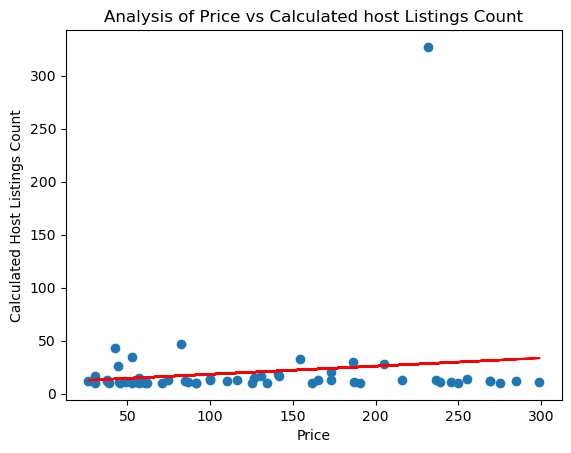

In [312]:
#Price so far is the strongest correlation out of all the considered variablees so far at 0.15,
# and there seems to be some reason for that. Looking at the scatter plot also shows no general
# increasing or general decreasing relationship. Lets calculate the significance of the correlation
# to see if it indicates a linear relationship at all.
slope,intercept = np.polyfit(busydata1['price'],busydata1['calculated_host_listings_count'],1)
print("y="+str(slope)+"x"+"+"+str(intercept))
corr,p_value=scipy.stats.pearsonr(busydata1['price'],busydata1['calculated_host_listings_count'])
print(corr)
print("P value is:"+ str(p_value))
# We can see here from the p_value of 0.26 that this correlation coefficient is not significant enough
# for us to consider this to have any indicitive effect as described by the line of best fit. There may 
# be some reasons why there is a slightly positive correlation, including maybe people who post higher_value
# property tend to be richer, own more property, therefore list more on AirBnb. However, analyzing here tells us
# That this relationship seems to be insignificant.
plt.scatter(busydata1['price'],busydata1['calculated_host_listings_count'])
plt.plot(busydata1['price'],slope*busydata1['price']+intercept,color='red')
plt.xlabel('Price')
plt.ylabel('Calculated Host Listings Count')
plt.title("Analysis of Price vs Calculated host Listings Count")
plt.show()

y=0.6890372806006128x+18.802979572210738
Pearson corr is: 0.028371892372380907
p value is 0.8325652128586063
Spearman corr is: -0.19103816551386785
p value is: 0.3833555290072327


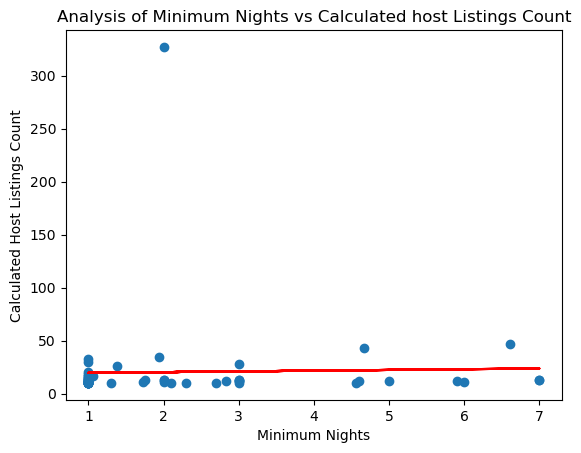

In [313]:
#Lets try the same approach with minimum nights
slope,intercept=np.polyfit(busydata1['minimum_nights'],busydata1['calculated_host_listings_count'],1)
plt.scatter(busydata1['minimum_nights'],busydata1['calculated_host_listings_count'])
plt.plot(busydata1['minimum_nights'],slope*busydata1['minimum_nights']+intercept,color='red')
print("y="+str(slope)+"x"+"+"+str(intercept))
corr,p_value=scipy.stats.pearsonr(busydata1['minimum_nights'],busydata1['calculated_host_listings_count'])
print("Pearson corr is: "+str(corr))
print("p value is "+str(p_value))
corr,p_value= scipy.stats.spearmanr(busydata1['number_of_reviews'],busydata1['calculated_host_listings_count'])
print("Spearman corr is: "+str(corr))
print("p value is: "+str(p))
plt.xlabel('Minimum Nights')
plt.ylabel('Calculated Host Listings Count')
plt.title("Analysis of Minimum Nights vs Calculated host Listings Count")
plt.show()



#Here, the correlation coefficient is very low at 0.02, and the p value is extremely high
# indicating that there is no establishable correlation between minimum nights and # of listings

y=-0.09818271477480366x+23.372337401738914
Pearson corr is: -0.1099137088554113
p value is 0.411447779892027
Spearman corr is: -0.19103816551386785
p value is: 0.3833555290072327


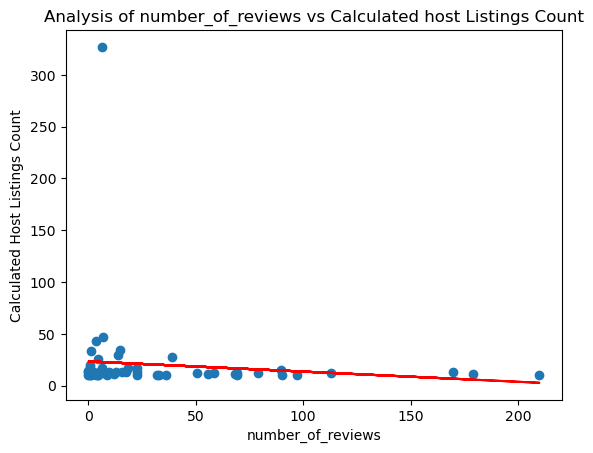

In [314]:
#What about number of reviews? 

slope,intercept=np.polyfit(busydata1['number_of_reviews'],busydata1['calculated_host_listings_count'],1)
plt.scatter(busydata1['number_of_reviews'],busydata1['calculated_host_listings_count'])
plt.plot(busydata1['number_of_reviews'],slope*busydata1['number_of_reviews']+intercept,color='red')
print("y="+str(slope)+"x"+"+"+str(intercept))
corr,p_value=scipy.stats.pearsonr(busydata1['number_of_reviews'],busydata1['calculated_host_listings_count'])
print("Pearson corr is: "+str(corr))
print("p value is "+str(p_value))
corr,p_value= scipy.stats.spearmanr(busydata1['number_of_reviews'],busydata1['calculated_host_listings_count'])
print("Spearman corr is: "+str(corr))
print("p value is: "+str(p))
plt.xlabel('number_of_reviews')
plt.ylabel('Calculated Host Listings Count')
plt.title("Analysis of number_of_reviews vs Calculated host Listings Count")
plt.show()


#Here, correlation coefficient shows a relatively small negative correlation, with a p value of 
#0.411, showing that the correlation coefficient is not significant in indicating a linear realtionship.
#The slope is also very near 0 as well. There seems to be no relationship between number of reviews
# and number of listing

y=0.030184075707201153x+13.07745530488901
Pearson corr is: 0.08044514537491876
p value is 0.5483133321563156
Spearman corr is: 0.09200877701232292
p value is: 0.3833555290072327


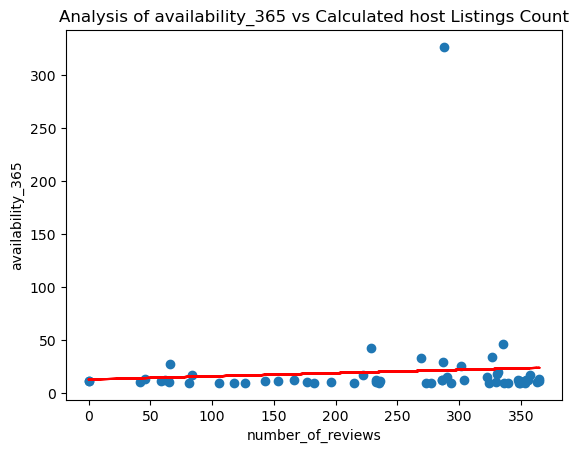

In [315]:
#How about availability_365?

slope,intercept=np.polyfit(busydata1['availability_365'],busydata1['calculated_host_listings_count'],1)
plt.scatter(busydata1['availability_365'],busydata1['calculated_host_listings_count'])
plt.plot(busydata1['availability_365'],slope*busydata1['availability_365']+intercept,color='red')
print("y="+str(slope)+"x"+"+"+str(intercept))
corr,p_value=scipy.stats.pearsonr(busydata1['availability_365'],busydata1['calculated_host_listings_count'])
print("Pearson corr is: "+str(corr))
print("p value is "+str(p_value))
corr,p_value= scipy.stats.spearmanr(busydata1['availability_365'],busydata1['calculated_host_listings_count'])
print("Spearman corr is: "+str(corr))
print("p value is: "+str(p))
plt.xlabel('number_of_reviews')
plt.ylabel('availability_365')
plt.title("Analysis of availability_365 vs Calculated host Listings Count")
plt.show()

#There also is no significant p value for the correlation coefficient of availability vs listing count
# indicating that there is no significant correlation here. One possible explanation for the slight positve correlation 
# is that more availabilities within the next 365 days mean more free time to post on airbnb and try to rent the homes out.
# However, this is also clearly not indicative.


In [ ]:
# In conclusion, with regards to the scattermap we observed, at how areas of Manhattan and some of Queens have the busiest 
# hosts, as well as how Price out of the four parameters we considered above was the most indicative with the highest correlation
# and lowest p value, the main contributing factor in how frequently a host lists of the parameters provided in the data set seems 
# to be demand. It makes sense that Manhattan out of the five areas is the most in demand as Manhattan is the most famous and in demand
# location out of the five New York Areas. This is also explained by how a good amount of busy hosts post high prices as Manhattan property
# is on average the most expensive.

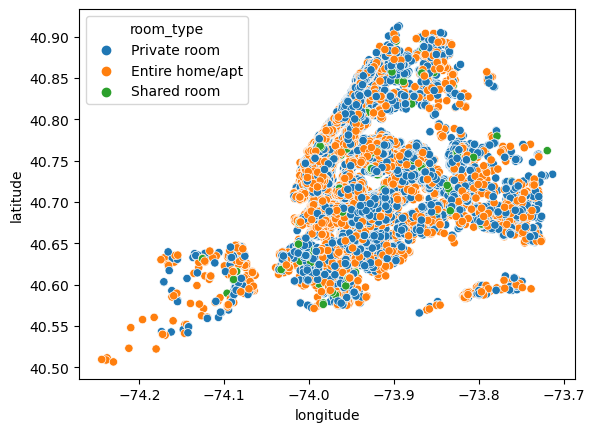

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_range,listing_range
count,32474.000,32474.000,32474.000,32474.000,32474.000,32474.000,32474.000,32474.000,32474.000,32474.000,32474.000,32474.000
mean,18359957.075,64832088.662,40.727,-73.949,117.227,2.569,31.949,1.494,3.375,104.034,1.899,0.530
std,10615956.210,75763203.055,0.056,0.048,65.063,1.599,50.564,1.748,21.721,125.304,1.368,1.006
min,2539.000,2787.000,40.506,-74.244,0.000,1.000,1.000,0.010,1.000,0.000,0.000,0.000
25%,9096707.000,7334458.250,40.687,-73.981,65.000,1.000,3.000,0.220,1.000,0.000,1.000,0.000
50%,19227180.000,29737743.000,40.720,-73.953,100.000,2.000,11.000,0.870,1.000,39.000,2.000,0.000
75%,27736580.500,102410496.000,40.763,-73.931,150.000,3.000,38.000,2.260,2.000,191.000,3.000,1.000
max,36455809.000,273841667.000,40.913,-73.713,321.000,8.000,629.000,58.500,327.000,365.000,6.000,5.000


In [319]:
#Lets analyze if location plays a matter in what type of property is being rented

datatouse = data[data['price']<322]
datatouse=datatouse[datatouse['minimum_nights']<9]
seaborn.scatterplot(x='longitude',y='latitude',hue='room_type',data=datatouse)
plt.show()
datatouse.describe()

In [318]:
#We can see here that lower Manhattan has a lot of entire homes/apts, and 
#upper Manhattan has a lot of Private rooms and a share of entire homes.
#We also see that most of Brooklyn are private rooms, with some 
# entire homes bordering Manhattan.
#about 40% of Queens is private entire homes and apartment with most of the rest being private rooms.
#Therefore, is there a clear hierchy between which type of room costs more?
#meandata= neighbors.agg({'price':['mean','median','count']}).sort_values(('price','mean'))
price_by_type=datatouse.groupby('room_type').agg({'price':['mean','median','count']}).sort_values(('price','mean'))
price_by_type



price               
                   mean  median  count
room_type                             
Shared room      57.467  48.000    751
Private room     78.724  70.000  15995
Entire home/apt 159.238 150.000  15728

In [323]:
price_by_region = datatouse.groupby('neighbourhood_group').agg({'price':['mean','median','std','count']})
price_by_region

#Here, we can see that Manhattan and Brooklyn are clearly the most expensive neighbourhoods

price                      
                       mean  median    std  count
neighbourhood_group                              
Bronx                75.508  65.000 45.082    821
Brooklyn            106.675  90.000 59.702  14274
Manhattan           141.254 129.000 67.280  12925
Queens               89.144  74.000 52.575   4156
Staten Island        87.195  72.000 55.316    298

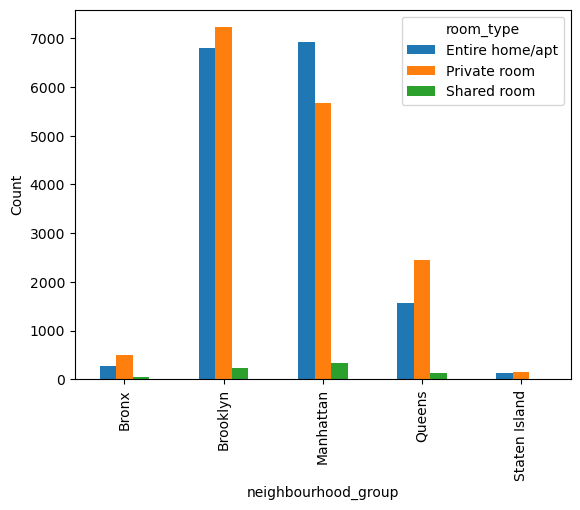

In [325]:
room_counts = datatouse.groupby(['neighbourhood_group','room_type']).size().unstack()
room_counts.plot(kind='bar',stacked=False)
plt.ylabel('Count')
plt.show()

#From this plot, we can see why: Most of Entire home/apartment or private rooms are dominated
# by Manhattan and Brooklyn, showing why they are the most expensive neighbourhood
# areas. It seems like price of neighbourhood is more dependent upon the type of room 
# the neighbourhood group typically offers rather than the location itself.